# HDDM analysis of EMBARC PRT data 

In [1]:
import datetime, mmap,os,re, sys, hddm, decimal 
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
# below makes graphs open in the nb instead of in a separate window
% matplotlib inline 
% load_ext rpy2.ipython

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [4]:
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/' + state + '/'
    temp_dir = base_dir + abrev + 'Temp/'
    old_files = base_dir + 'embarc_CU_' + abrev + '0*/done/sigdet_output*out'
    flist = !ls {old_files}
    
    !mkdir {temp_dir}
    
    for old_fname in flist:
        if abrev != 'CU':
            sub = old_fname.split('_')[2]
        else:
            sub = old_fname.split('_')[3]
        new_file = sub + '_out.txt'
        new_fname = temp_dir + new_file
        
        !cp {old_fname} {new_fname} # Done this way you don't get error messages when there's no old file

mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/: File exists
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/New_York/CUTemp/: File exists
usage: cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file target_file
       cp [-R [-H | -L | -P]] [-fi | -n] [-apvX] source_file ... target_directory
mkdir: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/: File exists


In [5]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'rich_due':line.split('\t')[7],
                             'lean_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('rich_key','Rich key:'),('lean_key','Lean key:'), ('subject','Subject ID:'), ('date','Date:'), 
                ('bias','Bias:'), ('rich_stim','Rich stimulus:'), ('lean_stim','Lean stimulus:')]:
        
        var_name, pattern = val
        df[var_name] = np.nan # Need some default values b/c some subjects have missing data        

        if var_name != 'date':
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        else:
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        
        with open(fname) as f:
            for line in f:
                var_match = var_def.search(line)
                if var_match:
                    result = var_match.group(1)
                    #checks if the subject ID is weird, prints it, and fixes it. For this data, all 3 digit sub ids
                    #are fixed by adding a 0 to the beginning. 
                    if var_name =='subject' and len(result) !=4:
                        print ('Check sub ID: ' + fname)
                        if len(result) == 3:
                            df[var_name]='0'+ result
                        if len(result) == 1:
                            df[var_name] ='000' + result
                    else:
                        df[var_name] = result

    return df

In [5]:
# Now you can just iterate over the files in each dir and use the code above to read each file into a ginorm df
today = datetime.datetime.today().strftime("%m_%d_%Y")

dfs = []
base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/'
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    state_dir = base_dir + state + '/' + abrev + 'Temp'
    flist = !ls {state_dir}
    
    for fname in flist:
        curr_path = state_dir + '/' + fname 
        statinfo = os.stat(curr_path) # checking for empty files b/c I found one . . .
        if statinfo.st_size == 0:
            #to make it compatible with 2 & 3
            print ('Empty file: '+ curr_path)
        else:
            df = SigDetParse(curr_path)
            df['site'] = abrev
            df['ProjectSpecificID'] = df['site'] + df['subject']
            dfs.append(df)
out = pd.concat(dfs)
out = out[['ProjectSpecificID','site','subject','date','bias','rich_stim','lean_stim','rich_key','lean_key',
           'trial','length','time','key_press','correct','did_reward','reward_due','rich_due','lean_due','outlier']]
out.to_csv(path2analysis + 'embarc_PRT_one_sess_' + today + ' .csv')

Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0020MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0025MGBP2R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0027MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0039MGBP2R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0270MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/UM0001UMBP1R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0038MGBP3R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Texas/TXTemp/TX0198TXBP2R1_out.txt


In [6]:
# Definitely should redo based on date (or just remove duplicates, would prob be very short)
# Also redo to check the new list against the standard analysis file/christian's
dfs = []
base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/'
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    state_dir = base_dir + state + '/' + abrev + 'Temp'
    state_one_sess = base_dir + state + '/' + abrev + 'Temp/*P1*'
    flist = !ls {state_dir}
    flist_one_sess = !ls {state_one_sess}
    
    for fname in flist_one_sess:
        curr_path = fname   
        statinfo = os.stat(curr_path) # checking for empty files b/c I found one . . .
        if statinfo.st_size == 0:
            #to make it compatible with 2 & 3
            print ('Empty file: ' + curr_path)
        else:
            df = SigDetParse(curr_path)
            df['site'] = abrev
            df['ProjectSpecificID'] = df['site'] + df['subject']
            dfs.append(df)
out = pd.concat(dfs)
out = out[['ProjectSpecificID','site','subject','date','bias','rich_stim','lean_stim','rich_key','lean_key',
           'trial','length','time','key_press','correct','did_reward','reward_due','rich_due','lean_due','outlier']]
out.to_csv(path2analysis + 'embarc_PRT_one_sess_' + today + '.csv')

Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0020MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0027MGBP1R1_out.txt
Empty file: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Massachusetts/MGTemp/MG0270MGBP1R1_out.txt
Check sub ID: /Users/mlm2/Work/Expts/EMBARC/Data/PRT/Michigan/UMTemp/UM0001UMBP1R1_out.txt


In [7]:
out.head()

,ProjectSpecificID,site,subject,date,bias,rich_stim,lean_stim,rich_key,lean_key,trial,length,time,key_press,correct,did_reward,reward_due,rich_due,lean_due,outlier
0,MG0001,MG,0001,12/14/2011,short,short,long,c,m,1,short,683,c,1,0,0,0,0,0
1,MG0001,MG,0001,12/14/2011,short,short,long,c,m,2,long,1307,c,0,0,1,0,1,1
2,MG0001,MG,0001,12/14/2011,short,short,long,c,m,3,short,577,c,1,1,1,0,1,0
3,MG0001,MG,0001,12/14/2011,short,short,long,c,m,4,long,677,m,1,1,1,0,0,0
4,MG0001,MG,0001,12/14/2011,short,short,long,c,m,5,short,724,c,1,0,0,0,0,0


In [8]:
out.tail()

,ProjectSpecificID,site,subject,date,bias,rich_stim,lean_stim,rich_key,lean_key,trial,length,time,key_press,correct,did_reward,reward_due,rich_due,lean_due,outlier
195,TX0204,TX,0204,10/12/2015,short,short,long,c,m,196,short,686,m,0,0,1,1,0,0
196,TX0204,TX,0204,10/12/2015,short,short,long,c,m,197,long,365,m,1,1,1,1,0,0
197,TX0204,TX,0204,10/12/2015,short,short,long,c,m,198,long,846,m,1,0,0,1,0,0
198,TX0204,TX,0204,10/12/2015,short,short,long,c,m,199,short,414,c,1,1,1,0,0,0
199,TX0204,TX,0204,10/12/2015,short,short,long,c,m,200,short,1083,c,1,0,0,0,0,0


In [12]:
# Check that change fixed the wacky numbers, looks like it did
out.subject.unique()

array(['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008',
       '0018', '0020', '0021', '0025', '0027', '0028', '0030', '0032',
       '0039', '0040', '0051', '0060', '0064', '0066', '0069', '0070',
       '0074', '0076', '0081', '0086', '0101', '0104', '0106', '0112',
       '0116', '0117', '0120', '0125', '0126', '0135', '0137', '0138',
       '0142', '0152', '0155', '0157', '0158', '0161', '0164', '0168',
       '0172', '0180', '0182', '0185', '0187', '0198', '0202', '0206',
       '0207', '0209', '0213', '0214', '0218', '0220', '0222', '0228',
       '0230', '0231', '0238', '0239', '0242', '0243', '0246', '0248',
       '0251', '0252', '0253', '0256', '0257', '0259', '0261', '0269',
       '0270', '0009', '0011', '0012', '0014', '0015', '0016', '0017',
       '0023', '0024', '0029', '0031', '0033', '0034', '0035', '0036',
       '0037', '0038', '0042', '0046', '0047', '0048', '0049', '0050',
       '0052', '0056', '0058', '0065', '0073', '0077', '0078', '0079',
      

In [21]:
#Combines the group data (groups.csv) with the task data, is really big, prob best to not work with
df_task = pd.read_csv('embarc_PRT_one_sess_11_15_2016.csv')
df_group = pd.read_csv('groups.csv',encoding="latin-1")
df_all = df_task.merge(df_group, how='outer')

df_all.to_csv('embarc_combined_' + today+'.csv')

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,104,109,113,117,118,119,122,123,127,133,134,135,136,138,141,142,219,221,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,250,251,252,253,258,260,262,264,266,268,276,280,283,285,287,290,293,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,336,338,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,392,396,408,410,411,417,418,419,421,422,423,460,462,464,466,468,470,472,474,476,478,480,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,590,800,801,812,813,814,823,861) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
# only use ppl w/ behavioral data (Some people in the group file don't have behavioral data and are on the bottom of the file)
# only use the needed columns. There is definitely a better way to do this
df_reuse = df_all.ix[0:79769, 1:23]

# renaming time & correct; the hddm package requires specific column names
df_reuse.rename(columns={'time':'rt', 'correct': 'response', 'ProjectSpecificID': 'subj_idx'}, inplace = True)

df_reuse.loc[df_reuse['feasibility'] == 1, 'feasibility'] = 'MDD'
df_reuse.loc[df_reuse['feasibility'] == 3, 'feasibility'] = 'MDD'
df_reuse.loc[df_reuse['feasibility'] == 5, 'feasibility'] = 'MDD'
df_reuse.loc[df_reuse['feasibility'] == 4, 'feasibility'] = 'CTL'

#don't include the predefined outlier trials
df_reuse = df_reuse[df_reuse.outlier != 1]

#save it as embarc_compact...
df_reuse.to_csv('embarc_compact_' + today+ '.csv')

# Standard Analysis

## Notes:
#### Massachusetts:
MG0081 & MG0164 had two sessions labled '1.' Since both sessions were complete, the ones with the earlier dates were used. Christian included MG020, which was originally coded as only having a session two; this was probably a typo and I included it. After these corrections everything matched, except that Christian's list included MG0164 twice (so our n for MDDs is one less than his). 

Our descriptives are a little different than Christian's, even in the HCs. 
#### New York: 
CU0017, CU0018, and CU0019 had two sessions labled '1.' Since both sessions were complete and had all data I just took the ones with the earlier dates. Christian also excluded CU0047, so I removed them from ours. It's unclear from the data why they were excluded. 

Our descriptives look the same as Christian's.
#### Michigan:
UM0012 & UM0017 had two sessions labled '1.' Since both sessions were complete I took the first of the two for each. UM0016 had three lines of the exact same session 1 data, so I only included the first line. Christian also excluded UM0102, so I removed them from ours. It's unclear from the data why they were excluded.

Our descriptives look the same as Christian's except our MDD n is 51 and his is 52. I would guess that UM0102 was not included in the list of subIDs that were included, but was included when doing the descriptives. We should decide whether or not to keep this person. 
#### Texas:
Everything lined up with no alterations!

Our descriptives look the same as Christian's.

In [156]:
#replaces the tabs in the files with spaces, returns 1 file for each state that has data for that state
#this should 100% be rewritten
def replacetabs(state):
    '''Open the file, replace the tabs with spaces, save the new doc as a csv.'''
    !mkdir {'/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp'}
    statesum = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/embarc*/*txt'
    folders = !ls -d {statesum}
    newfolders = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp/'
    newfolders2 = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/Temp'
    dfall = []
    for file in folders:
        !cp {file} {newfolders}
    for filename in os.listdir(newfolders):
        if filename != 'embarc_MG_subj_PRTsess_.txt' and filename != 'embarc_NY_subj_PRTsess_.txt'and filename != 'embarc_NY_subj****************_PRTsess2_short.txt' and filename != 'embarc_TX_subj_PRTsess_.txt' and filename != 'embarc_UM_subj_PRTsess_.txt' and filename !='Note.txt':
            f = open(newfolders + filename, 'r', encoding='windows-1252')
            for eachline in f:
                string=re.sub(r'\t',' ',eachline)
                open('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/' + state +'/Summaries/'+ filename,'a').write(string)
                df_this = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/' + state +'/Summaries/'+ filename, ' ', dtype={'subject':str})
                dfall.append(df_this)
    out = pd.concat(dfall)      
    out.to_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Standard' +state+ '.csv')


In [33]:
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    standard_file = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Standard'+ state +'.csv'
    one_sess_file = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'_one_sess_stand.csv'
    all_sess_file = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'_all_sess_stand.csv'
    
    # this is problematic, can only do once eek
    #replacetabs(state)
    
    df_state = pd.read_csv(standard_file, dtype={'subject':str}) 
    df_state.subject = df_state.subject.str.zfill(4)
    df_state['ProjectSpecificID'] =  abrev + df_state.subject
    
    df_group = pd.read_csv('groups.csv',encoding="latin-1")
    df_group = df_group[np.isfinite(df_group['feasibility'])]
    df_group = df_group.loc[df_group['feasibility'] != 2]
    
    df_all = df_state.merge(df_group, how='outer')
    df_all.loc[df_all['ProjectSpecificID'] == 'MG0020', 'session'] = 1 #recode this presumed typo
    df_all = df_all.loc[df_all['PRT_QC_Status'] == 1]
    df_all = df_all[np.isfinite(df_all['feasibility'])]
    df_firstsess = df_all.drop_duplicates('ProjectSpecificID')
    
    if abrev == 'MG':
        df_firstsess = df_firstsess.loc[df_all['session'] == 1]
    else:
        df_firstsess = df_firstsess.loc[df_all['session'] == '1']

    # Comparing to Christian's list
    df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)
    df_christian = df_christian.loc[df_christian[0].str.startswith(abrev)]
    christian_list = df_christian[0]
    # are we missing anything?
    for subject in christian_list:
        if subject in df_firstsess.ProjectSpecificID.unique():
            pass
        else:
            print('Missing from ours: '+ subject)
    # do we have anything extra?
    for subject in df_firstsess.ProjectSpecificID:
        if subject in christian_list.unique():
            pass
        else:
            print('Not included in Christians: ' + subject)
    if abrev == 'UM':
        print (christian_list.nunique())
    # Based on Christian's list, remove these people
    df_firstsess = df_firstsess.loc[df_all['ProjectSpecificID'] != 'UM0102']
    df_firstsess = df_firstsess.loc[df_all['ProjectSpecificID'] != 'CU0047']
    
    #save these bad boys
    #df_all.to_csv(all_sess_file)
    #df_firstsess.to_csv(one_sess_file)

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,104,109,113,117,118,119,122,123,127,133,134,135,136,138,141,142,219,221,227,229,231,232,233,234,235,236,237,238,239,240,241,242,243,244,250,251,252,253,258,260,262,264,266,268,276,280,283,285,287,290,293,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,336,338,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,392,396,408,410,411,417,418,419,421,422,423,460,462,464,466,468,470,472,474,476,478,480,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,590,800,801,812,813,814,823,861) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Not included in Christians: UM0102
61
Not included in Christians: CU0047


#### Massachusetts descriptives

count    52.000000
mean      0.011224
std       0.224892
min      -0.615990
25%      -0.136113
50%       0.022822
75%       0.166455
max       0.435866
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     8.000000
             mean      0.045439
             std       0.127056
             min      -0.151984
             25%      -0.051918
             50%       0.091124
             75%       0.139683
             max       0.186840
MDD          count    44.000000
             mean      0.005003
             std       0.238957
             min      -0.615990
             25%      -0.167264
             50%       0.007921
             75%       0.170126
             max       0.435866
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


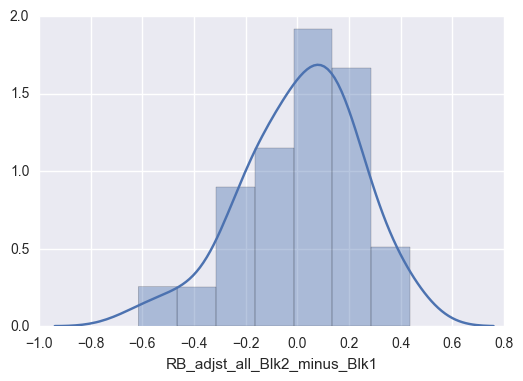

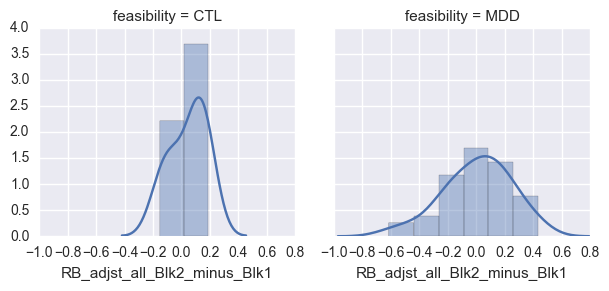

In [41]:
df_mg = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Massachusetts_one_sess_stand.csv')

df_mg.loc[df_mg['feasibility'] == 1, 'feasibility'] = 'MDD'
df_mg.loc[df_mg['feasibility'] == 3, 'feasibility'] = 'MDD'
df_mg.loc[df_mg['feasibility'] == 5, 'feasibility'] = 'MDD'
df_mg.loc[df_mg['feasibility'] == 4, 'feasibility'] = 'CTL'

print (df_mg.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_mg.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_mg.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_mg.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

#### New York descriptives

count    87.000000
mean      0.031472
std       0.239658
min      -0.520999
25%      -0.122641
50%       0.035868
75%       0.164572
max       0.638521
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     9.000000
             mean      0.071565
             std       0.259586
             min      -0.304479
             25%      -0.028772
             50%       0.080845
             75%       0.196364
             max       0.529251
MDD          count    78.000000
             mean      0.026846
             std       0.238618
             min      -0.520999
             25%      -0.124694
             50%       0.033628
             75%       0.161228
             max       0.638521
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


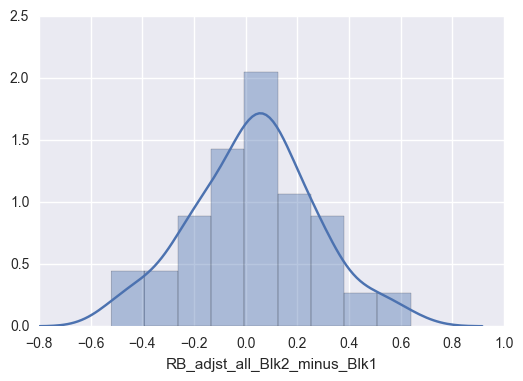

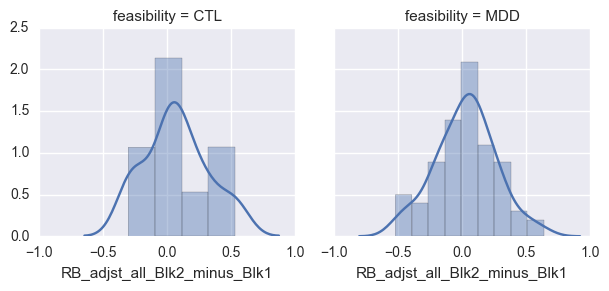

In [42]:
df_cu = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/New_York_one_sess_stand.csv')
df_cu.loc[df_cu['feasibility'] == 1, 'feasibility'] = 'MDD'
df_cu.loc[df_cu['feasibility'] == 3, 'feasibility'] = 'MDD'
df_cu.loc[df_cu['feasibility'] == 5, 'feasibility'] = 'MDD'
df_cu.loc[df_cu['feasibility'] == 4, 'feasibility'] = 'CTL'

print (df_cu.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_cu.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_cu.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_cu.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

#### Michigan descriptives

count    61.000000
mean      0.066889
std       0.192529
min      -0.383130
25%      -0.040539
50%       0.079934
75%       0.166309
max       0.744152
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count    10.000000
             mean     -0.013180
             std       0.218693
             min      -0.383130
             25%      -0.170711
             50%       0.017994
             75%       0.126936
             max       0.307409
MDD          count    51.000000
             mean      0.082588
             std       0.185307
             min      -0.246151
             25%      -0.034808
             50%       0.083179
             75%       0.169503
             max       0.744152
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


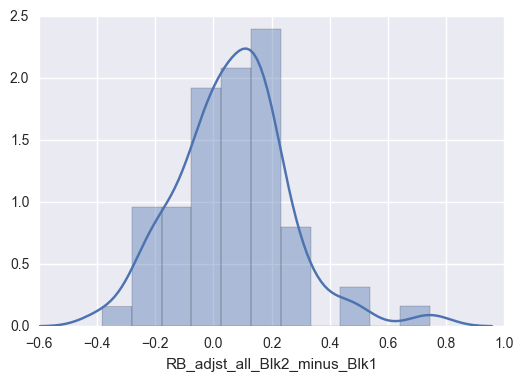

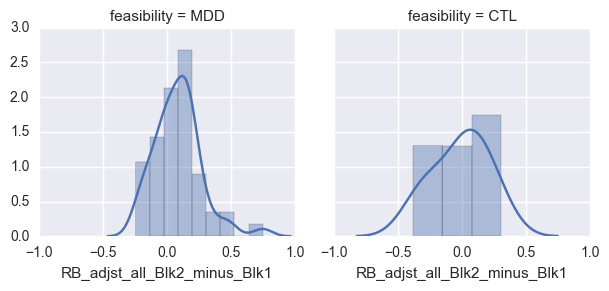

In [43]:
df_um = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Michigan_one_sess_stand.csv')
df_um.loc[df_um['feasibility'] == 1, 'feasibility'] = 'MDD'
df_um.loc[df_um['feasibility'] == 3, 'feasibility'] = 'MDD'
df_um.loc[df_um['feasibility'] == 5, 'feasibility'] = 'MDD'
df_um.loc[df_um['feasibility'] == 4, 'feasibility'] = 'CTL'

print (df_um.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_um.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_um.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_um.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

#### Texas descriptives

count    94.000000
mean     -0.011289
std       0.168048
min      -0.435213
25%      -0.105671
50%       0.010030
75%       0.103372
max       0.335822
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64
feasibility       
CTL          count     9.000000
             mean     -0.069607
             std       0.125213
             min      -0.249505
             25%      -0.154499
             50%      -0.055317
             75%       0.000000
             max       0.103666
MDD          count    85.000000
             mean     -0.005114
             std       0.171376
             min      -0.435213
             25%      -0.095460
             50%       0.022485
             75%       0.110149
             max       0.335822
Name: RB_adjst_all_Blk2_minus_Blk1, dtype: float64


/Users/mlm2/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


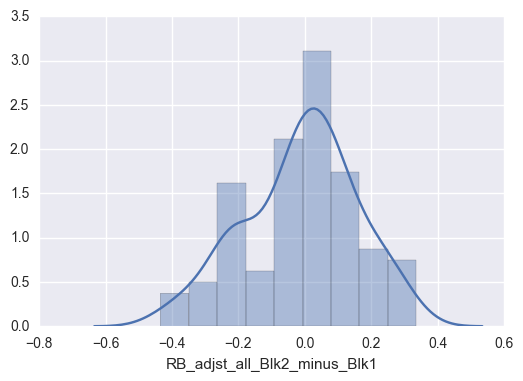

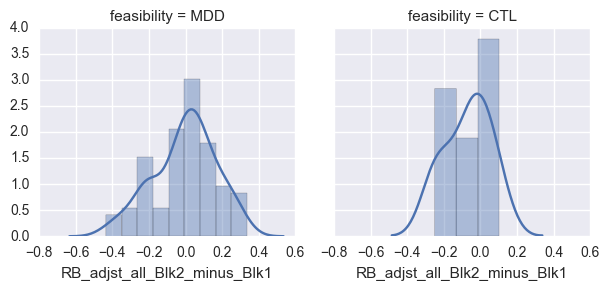

In [44]:
df_tx = pd.read_csv('/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/Texas_one_sess_stand.csv')
df_tx.loc[df_tx['feasibility'] == 1, 'feasibility'] = 'MDD'
df_tx.loc[df_tx['feasibility'] == 3, 'feasibility'] = 'MDD'
df_tx.loc[df_tx['feasibility'] == 5, 'feasibility'] = 'MDD'
df_tx.loc[df_tx['feasibility'] == 4, 'feasibility'] = 'CTL'

print (df_tx.RB_adjst_all_Blk2_minus_Blk1.describe())

t = df_tx.groupby(['feasibility'])
print (t.RB_adjst_all_Blk2_minus_Blk1.describe())

sns.distplot(df_tx.RB_adjst_all_Blk2_minus_Blk1.dropna())

group_fig = sns.FacetGrid(data=df_tx.dropna(axis=0,subset=['RB_adjst_all_Blk2_minus_Blk1']),col='feasibility',col_wrap=4)
group_fig.map(sns.distplot,'RB_adjst_all_Blk2_minus_Blk1')

 # Starting the HDDM part

In [24]:
data = hddm.load_csv('embarc_compact_' + today +'.csv')

# rt needs to be in seconds in order to fit to a model
data['rt'] = data['rt'] / 1000

data #looks good

,Unnamed: 0,subj_idx,site,subject,date,bias,rich_stim,lean_stim,rich_key,lean_key,...,key_press,response,did_reward,reward_due,rich_due,lean_due,outlier,sample,feasibility,trainingset
0,0,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
1,2,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,NaN
2,3,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,m,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,NaN
3,4,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
4,5,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
5,7,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,m,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
6,8,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,NaN
7,10,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,NaN
8,11,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,NaN
9,12,MG0001,MG,1.0,12/14/2011,short,short,long,c,m,...,c,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,NaN


In [25]:
print (hddm.__version__)

0.6.0


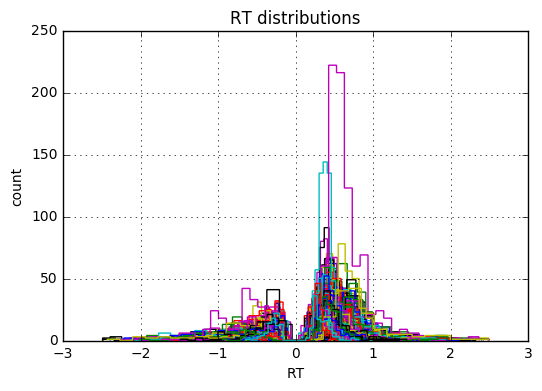

In [7]:
#flip error RTs so they become negative
data = hddm.utils.flip_errors(data)

#plot the RTs and save them 
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'): 
    subj_data.rt.hist(bins=30, histtype='step', ax=ax)
plt.savefig('RT_dist.pdf')

# it looks like there's one person with too many trials, should be fixed when the earlier cell is rewritten

In [9]:
#creates a simple model that doesn't take conditions into account
m=hddm.HDDM(data)

In [10]:
# this part has to do with Markov-Chain Monte Carlo (MCMC; https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
# it seems like MCMC gets the distribution of the posterior probababilities, which seem like 

m.find_starting_values()
m.sample(2000, burn=20)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 2001 of 2000 complete in 930.0 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [11]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.MG0001', 'a_subj.MG0002'])]

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.11777,0.0105155,1.0975,1.11065,1.11738,1.12505,1.13841,0.000237892
a_std,0.203753,0.0080986,0.188248,0.198159,0.203648,0.208833,0.22047,0.000223066
a_subj.MG0001,0.966903,0.0395581,0.893046,0.939422,0.966356,0.992233,1.05051,0.00138381
a_subj.MG0002,1.02424,0.0381826,0.952908,0.997553,1.022,1.04975,1.10384,0.00125358


Plotting a
Plotting a_std
Plotting v
Plotting t


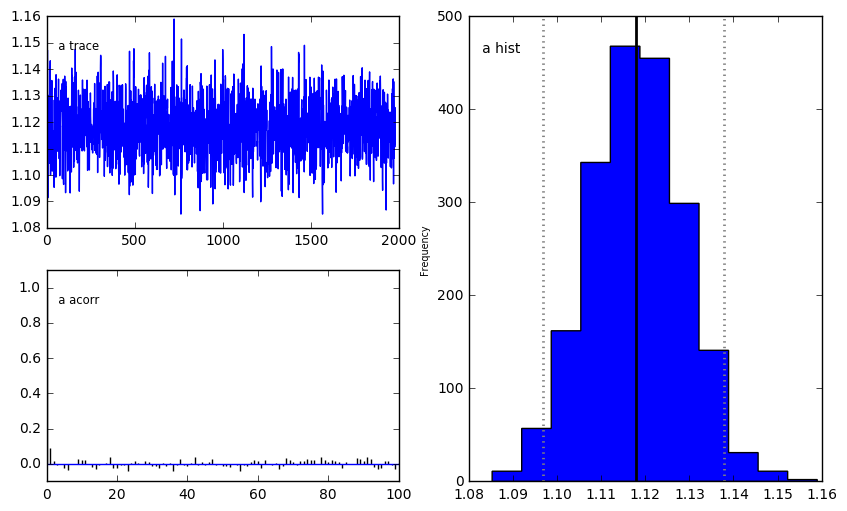

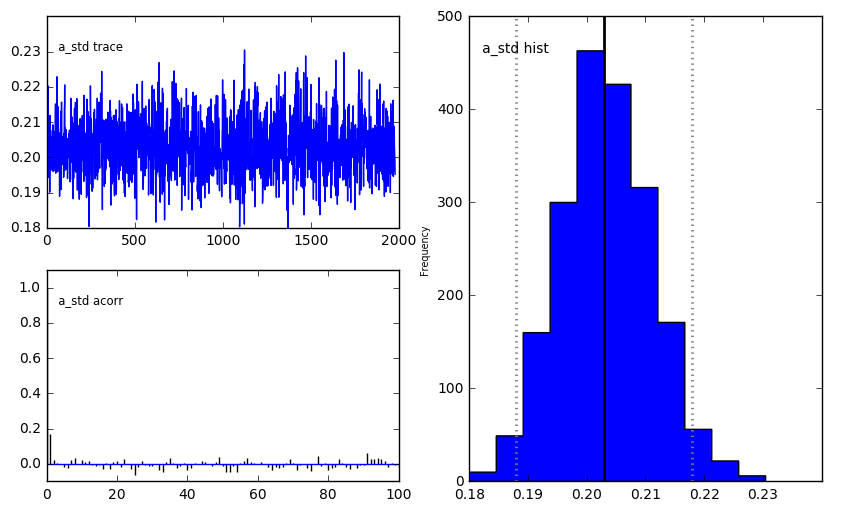

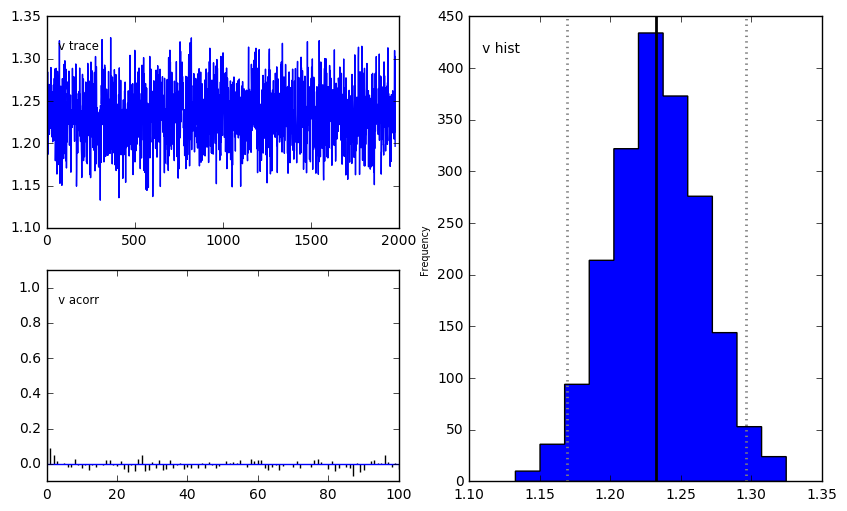

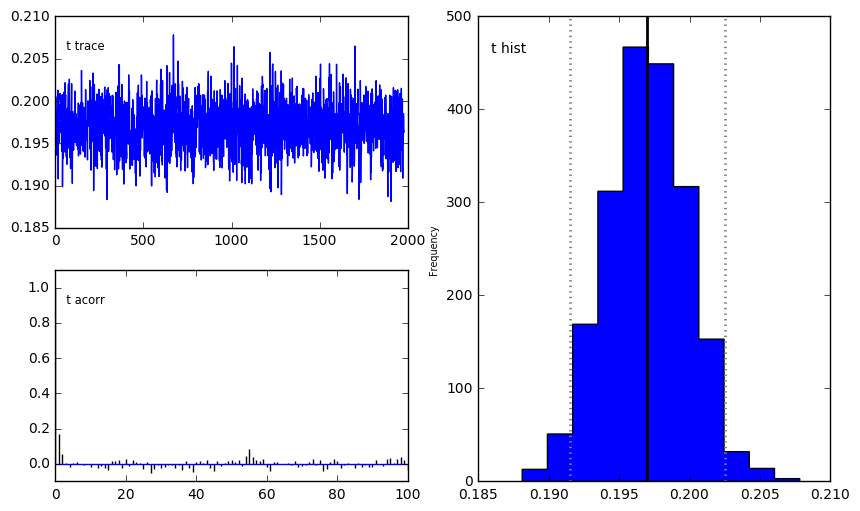

In [96]:
#From Demo:

# "The inference algorithm, MCMC, requires the chains of the model to have properly converged. 
#While there is no way to guarantee convergence for a finite set of samples in MCMC, there are 
#many heuristics that allow you identify problems of convergence. One main analysis to look at 
#is the trace, the autocorrelation, and the marginal posterior. You can plot these using the 
#plot_posteriors() function."

m.plot_posteriors(['a', 't', 'v', 'a_std'])

#we are looking for drifts or large jumps, based off of the example they gave it looks like 
#we're good

In [13]:
# TAKES FOREVER--don't do unless you need to. There might be something wrong here, it really 
# shouldn't take this long. 

# "The Gelman-Rubin statistic provides a more formal test for convergence that compares the 
# intra-chain variance to the intra-chain variance of different runs of the same model."

models = []

for i in range(5):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(5000, burn = 20)
    models.append(m)

#Values should be close to 1, and they are. 
hddm.analyze.gelman_rubin(models)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 5000 of 5000 complete in 2295.9 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


 [-----------------100%-----------------] 5000 of 5000 complete in 2329.0 sec

{'v_subj.MG0116': 1.0000330271386277,
 'a_subj.MG0202': 1.0031797798115387,
 't_subj.MG0239': 1.0008709134990033,
 't_subj.CU0025': 0.99996789508663497,
 'v_subj.UM0110': 0.99987041254054565,
 't_subj.CU0057': 0.9999668587419126,
 'a_subj.UM0042': 0.99987500286674869,
 't_subj.MG0209': 1.0005215435422659,
 't_subj.CU0015': 0.99994836557975342,
 'a_subj.UM0047': 1.0000050224138743,
 'v_subj.MG0008': 0.99998278155678899,
 'a_subj.UM0082': 1.0002061104929221,
 't_subj.MG0018': 0.99989415453595853,
 'a_subj.CU0014': 1.000423418562608,
 'a_subj.MG0161': 1.0000575414418862,
 'v_subj.TX0040': 0.99987293808940014,
 'v_subj.MG0259': 1.0000189709544942,
 'v_subj.CU0111': 0.99997696150829951,
 't_subj.CU0089': 1.0004601011954626,
 't_subj.MG0051': 0.99999264036549718,
 'v_subj.UM0008': 1.0000870255756769,
 'a_subj.MG0018': 0.99995199176824945,
 'a_subj.MG0021': 1.0002912664438319,
 'v_subj.TX0097': 1.0000415062847126,
 't_subj.CU0085': 1.0002154107811823,
 'v_subj.TX0106': 1.0000209547906733,
 'v

In [8]:
# for time's sake, I used 1000 & 100 to test, but it should really be 10000 & 1000
m_stim = hddm.HDDM(data, depends_on={'v': 'length'})
m_stim.find_starting_values()
m_stim.sample(1000, burn=100)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1001 of 1000 complete in 582.5 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


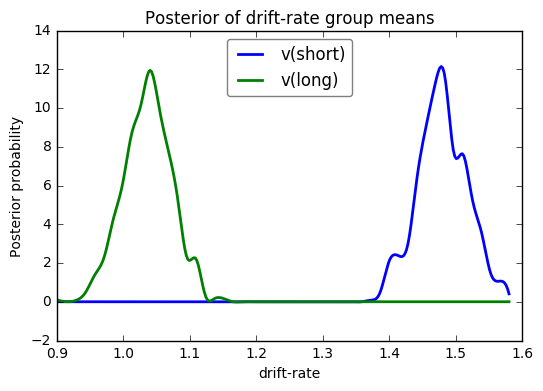

In [9]:
v_short, v_long = m_stim.nodes_db.node[['v(short)', 'v(long)']]
hddm.analyze.plot_posterior_nodes([v_short, v_long])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('long_short_drift_rate.pdf')

# think this makes sense because the short one is the rich stim always
# we are treating short/long like a between subjects factor though, so we should redo it, not
# sure how

In [26]:
# for time's sake, I used 1000 & 100 to test, but it should really be 10000 & 1000

m_stim = hddm.HDDM(data, depends_on={'v': 'feasibility'})
m_stim.find_starting_values()
m_stim.sample(1000, burn=100)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 1000 of 1000 complete in 435.6 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


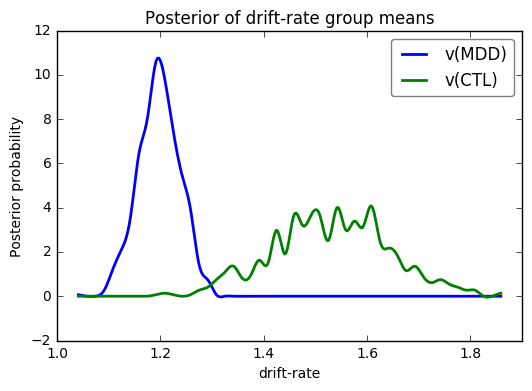

In [27]:
v_MDD, v_CTL = m_stim.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('long_short_drift_rate.pdf')

#I think this will be cleaned up a little when we run it with a larger sample